In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
df = pd.read_csv('./seattle-weather.xls')

In [19]:
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [20]:
df.isnull().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [21]:
#检查 Pandas DataFrame 中重复行的数量
df.duplicated().sum() 

0

In [22]:
#column Open converted into numpy array
training_set = df.iloc[:,2:3].values
training_set

array([[12.8],
       [10.6],
       [11.7],
       ...,
       [ 7.2],
       [ 5.6],
       [ 5.6]])

In [23]:
len(training_set)

1461

In [24]:
#通过滑动窗口的方式提取连续的时间段作为特征，并使用该时间段的下一个值作为预测目标
def df_to_XY(df,window_size=10):
 X_train=[]
 y_train=[]

 for i in range(10,len(training_set)):
    X_train.append(training_set[i-10:i,0])
    y_train.append(training_set[i,0])
    
 X_train, y_train = np.array(X_train), np.array(y_train)
 return X_train, y_train

In [25]:
WINDOW = 10
X,y = df_to_XY(df,WINDOW)
print(len(X),len(y))
X_train = X[:800]
y_train = y[:800]
X_val = X[800:1000]
y_val = y[800:1000]
X_test = X[1000:]
x_test = y[1000:]


1451 1451


In [26]:
#调整为三维的形状，以适应某些模型（如 RNN/LSTM/GRU）的输入要求
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [27]:
#Building the RNN
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [28]:
model = Sequential()

In [29]:
#Addinf the first LSTM layer and some Dropout regularisation
model.add(LSTM(units=50, return_sequences = True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

#Output layer
model.add(Dense(units=1))

In [30]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [32]:
#fitting the rnn to the training set
history=model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100, batch_size=32)

Epoch 1/100


2024-10-15 10:11:12.337579: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8400
2024-10-15 10:11:12.455153: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


25/25 [==============================] - 3s 33ms/step - loss: 203.0035 - val_loss: 264.4172
Epoch 2/100
25/25 [==============================] - 0s 8ms/step - loss: 102.2899 - val_loss: 180.7950
Epoch 3/100
25/25 [==============================] - 0s 13ms/step - loss: 77.6039 - val_loss: 146.9615
Epoch 4/100
25/25 [==============================] - 0s 12ms/step - loss: 67.3265 - val_loss: 125.6385
Epoch 5/100
25/25 [==============================] - 0s 9ms/step - loss: 60.8989 - val_loss: 111.0012
Epoch 6/100
25/25 [==============================] - 0s 12ms/step - loss: 57.9472 - val_loss: 99.2511
Epoch 7/100
25/25 [==============================] - 0s 12ms/step - loss: 55.4723 - val_loss: 91.8026
Epoch 8/100
25/25 [==============================] - 0s 9ms/step - loss: 55.1650 - val_loss: 86.5459
Epoch 9/100
25/25 [==============================] - 0s 10ms/step - loss: 54.1517 - val_loss: 82.8307
Epoch 10/100
25/25 [==============================] - 0s 9ms/step - loss: 53.8719 - val_lo

In [33]:

his = pd.DataFrame(history.history)

In [34]:

his.head()

,loss,val_loss
0,203.003510,264.417236
1,102.289886,180.794983
2,77.603874,146.961472
3,67.326523,125.638519
4,60.898930,111.001152


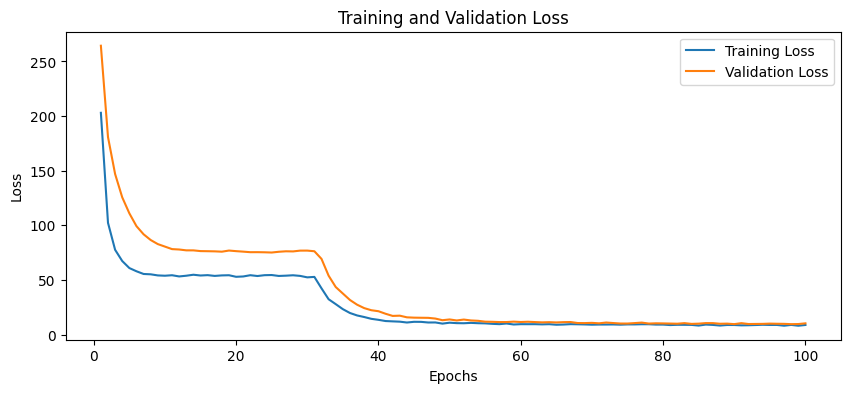

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# 提取训练损失和验证损失
history_loss = history.history['loss']
history_val_loss = history.history['val_loss']

# 创建一个 x 轴数据，即 epoch 序号
epochs = range(1, len(history_loss) + 1)

# 创建图形
plt.figure(figsize=(10, 4))

# 绘制训练损失曲线
plt.plot(epochs, history_loss, label='Training Loss')

# 绘制验证损失曲线
plt.plot(epochs, history_val_loss, label='Validation Loss')

# 图形标题和标签
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 显示图形
plt.show()


In [36]:

train_pred = model.predict(X_train).flatten()
val_pred = model.predict(X_val).flatten()
test_pred = model.predict(X_test).flatten()

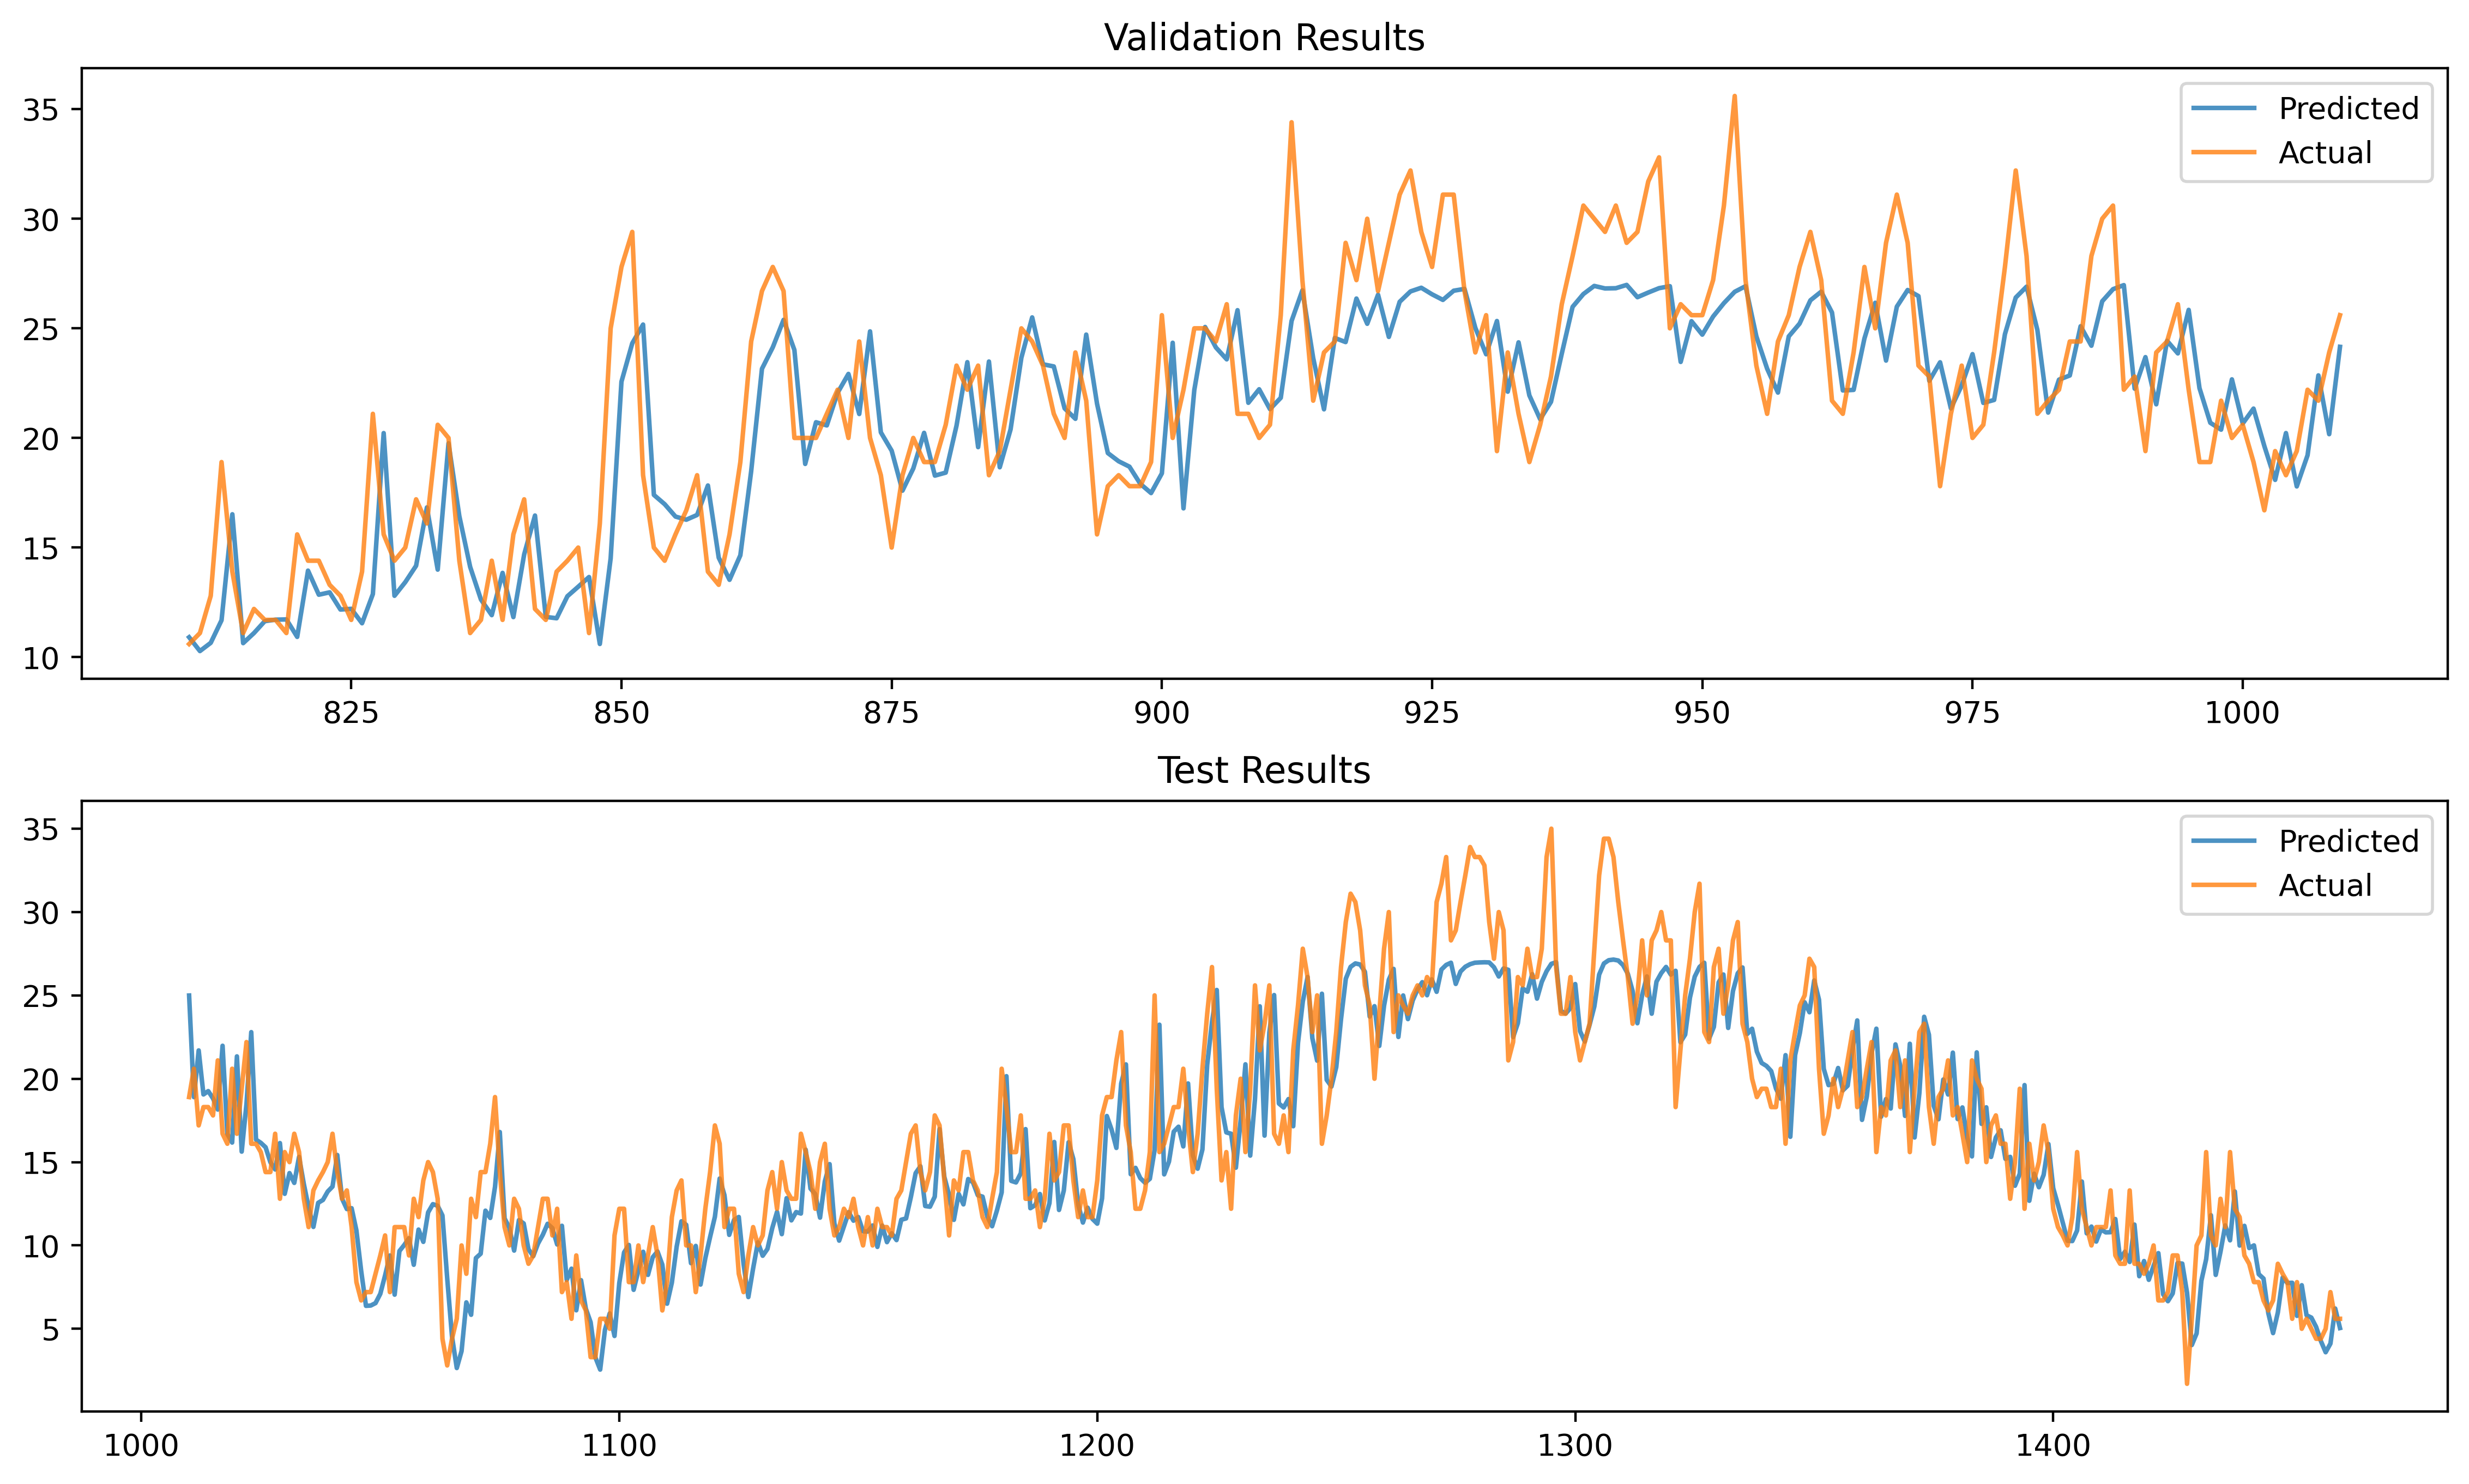

In [37]:
pred = np.concatenate([train_pred,val_pred,test_pred])
df_pred = pd.DataFrame(df["temp_max"].copy())
df_pred.columns=["actual"]
df_pred = df_pred[WINDOW:]
df_pred["predicted"] = pred

fig,axes = plt.subplots(2,1,figsize=(14,8),dpi=400)

plt.subplot(2,1,1)
plt.title("Validation Results")
plt.plot(df_pred['predicted'][800:1000], label='Predicted',alpha=0.8,linestyle=None)
plt.plot(df_pred['actual'][800:1000], label='Actual',alpha=0.8,linestyle=None)
plt.legend()
plt.subplot(2,1,2)
plt.title("Test Results")
plt.plot(df_pred['predicted'][1000:], label='Predicted',alpha=0.8,linestyle=None)
plt.plot(df_pred['actual'][1000:], label='Actual',alpha=0.8,linestyle=None)
plt.legend()